# Data Analysis - Metropolitan Museum of Art

This notebook contains the data checks and analysis on the Metropolitan Museum of Art Open Access Dataset, available at https://github.com/metmuseum/openaccess/.   

Overall observations of the data:
-Most data seems to be accurate and make sense, although there are many missing entries.  Most of these make sese, like missing entries in "locale" and original artist names where it cannot be determined.
-There are a few typos, namely some errors in dates of objects (e.g. 5000 instead of -5000).
-Artist display names and begin/end dates can be misleading as they can be a philanthropist or curator instead of the actual artist of the piece.  
-Some entry styles are also inconsistent and some cleaning is necessary to use some dates, countries, etc.
-These observations are not surprising as the data is currently being updated, as noted on the GitHub page.


Predictions:
-I wanted to see if the department that an object belongs to can be determined just from the title of the piece.  To do this I used a bag of words model from the titles and used a Naive Bayes and found a prediction accuracy of 77% was possible (the code is also set up to test an SVM as well but is time-consuming). 


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re, string
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import csv
from textblob import TextBlob
import pandas
import sklearn
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
%matplotlib inline



In [4]:
df = pd.read_csv("MetObjects.csv")

/Users/ian/.pyenv/versions/3.6.5/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (7,8,9,10,11,18,27,28,29,30,31,32,33,34,35,36,37,39) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491088 entries, 0 to 491087
Data columns (total 44 columns):
Object Number              491088 non-null object
Is Highlight               491088 non-null bool
Is Public Domain           491088 non-null bool
Object ID                  491088 non-null int64
Department                 491088 non-null object
Object Name                486902 non-null object
Title                      460006 non-null object
Culture                    208730 non-null object
Period                     89388 non-null object
Dynasty                    23285 non-null object
Reign                      11203 non-null object
Portfolio                  21956 non-null object
Artist Role                282897 non-null object
Artist Prefix              97871 non-null object
Artist Display Name        284987 non-null object
Artist Display Bio         236520 non-null object
Artist Suffix              11654 non-null object
Artist Alpha Sort          284954 non-null object


In [6]:
df.memory_usage()

Index                           80
Object Number              3928704
Is Highlight                491088
Is Public Domain            491088
Object ID                  3928704
Department                 3928704
Object Name                3928704
Title                      3928704
Culture                    3928704
Period                     3928704
Dynasty                    3928704
Reign                      3928704
Portfolio                  3928704
Artist Role                3928704
Artist Prefix              3928704
Artist Display Name        3928704
Artist Display Bio         3928704
Artist Suffix              3928704
Artist Alpha Sort          3928704
Artist Nationality         3928704
Artist Begin Date          3928704
Artist End Date            3928704
Object Date                3928704
Object Begin Date          3928704
Object End Date            3928704
Medium                     3928704
Dimensions                 3928704
Credit Line                3928704
Geography Type      

In [7]:
df.memory_usage().sum()

165987824

Let's see if we can reduce some memory usage by changing data types.

In [8]:
df.Department = df.Department.astype('category')
df.Culture = df.Culture.astype('category')
df.Dynasty = df.Dynasty.astype('category')
df.Classification = df.Classification.astype('category')

In [9]:
df.memory_usage()

Index                           80
Object Number              3928704
Is Highlight                491088
Is Public Domain            491088
Object ID                  3928704
Department                  491880
Object Name                3928704
Title                      3928704
Culture                    1367640
Period                     3928704
Dynasty                     995456
Reign                      3928704
Portfolio                  3928704
Artist Role                3928704
Artist Prefix              3928704
Artist Display Name        3928704
Artist Display Bio         3928704
Artist Suffix              3928704
Artist Alpha Sort          3928704
Artist Nationality         3928704
Artist Begin Date          3928704
Artist End Date            3928704
Object Date                3928704
Object Begin Date          3928704
Object End Date            3928704
Medium                     3928704
Dimensions                 3928704
Credit Line                3928704
Geography Type      

In [10]:
df.memory_usage().sum()

154160904

In [11]:
df.shape

(491088, 44)

There are 491,088 objects in the dataset with a lot of missing data (NaN values).  Some of this makes sense, like missing county and locale data.

In [5]:
df.describe()

,Object ID,Object Begin Date,Object End Date
count,491088.000000,491088.000000,491088.000000
mean,384095.879549,1308.658576,1407.705448
std,229877.336275,1657.564095,1152.111113
min,1.000000,-400000.000000,-240000.000000
25%,212437.750000,1535.000000,1593.000000
50%,373665.500000,1800.000000,1845.000000
75%,562354.250000,1900.000000,1911.000000
max,821130.000000,5000.000000,157555.000000


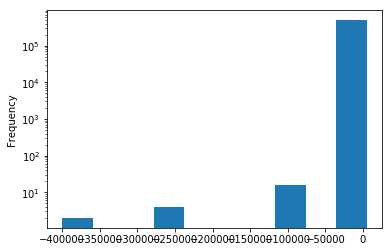

In [8]:
df['Object Begin Date'].plot(kind="hist",  logx=False, logy=True)
plt.show()

The only numerical columns are Object ID and Object Begin/End Dates.  It looks like these dates are years with some strange values, like -400000 and 157555. 

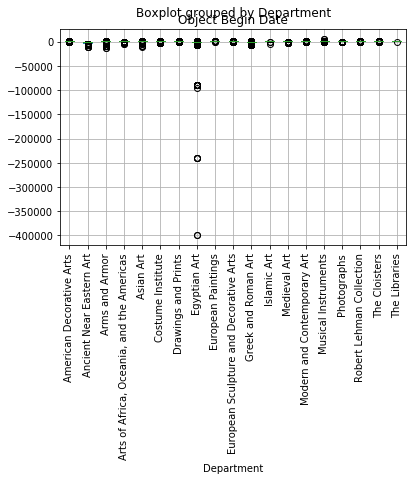

In [34]:
df.boxplot(column='Object Begin Date', by='Department', rot=90)

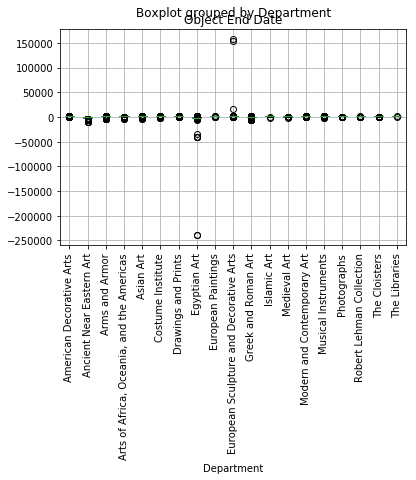

In [35]:
df.boxplot(column='Object End Date', by='Department', rot=90)

In [22]:
# Let's look at the very old Egyptian Art
very_old=df['Object Begin Date']<-200000.
df_very_old=df[very_old]
#df_very_old.shape
df_very_old
#print(df_62_635['Link Resource'])

,Object Number,Is Highlight,Is Public Domain,Object ID,Department,Object Name,Title,Culture,Period,Dynasty,...,Locale,Locus,Excavation,River,Classification,Rights and Reproduction,Link Resource,Metadata Date,Repository,Tags
375697,06.322.34,False,True,573090,Egyptian Art,"Tool, denticulate, Levallois",Denticulated Tool,NaN,Middle Paleolithic Period,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,http://www.metmuseum.org/art/collection/search...,2/4/2019 8:00:01 AM,"Metropolitan Museum of Art, New York, NY",Tools and Equipment
375699,06.322.37,False,True,573092,Egyptian Art,"Tool, point, Levallois",Retouched Levallois Point,NaN,Middle Paleolithic Period,NaN,...,NaN,NaN,NaN,NaN,|,NaN,http://www.metmuseum.org/art/collection/search...,2/4/2019 8:00:01 AM,"Metropolitan Museum of Art, New York, NY",NaN
375700,06.322.42,False,True,573093,Egyptian Art,"Core, Levallois",Levallois Core,NaN,Middle Paleolithic Period,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,http://www.metmuseum.org/art/collection/search...,2/4/2019 8:00:01 AM,"Metropolitan Museum of Art, New York, NY",Tools and Equipment
375701,06.322.43,False,True,573094,Egyptian Art,"Tool, Levallois, Point",Atypical Levallois Point,NaN,Middle Paleolithic Period,NaN,...,NaN,NaN,NaN,NaN,|,NaN,http://www.metmuseum.org/art/collection/search...,2/4/2019 8:00:01 AM,"Metropolitan Museum of Art, New York, NY",NaN
375703,06.322.48,False,True,573096,Egyptian Art,"Tool, Biface, Hand-axe, Ovate",Biface,NaN,Lower Paleolithic Period,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,http://www.metmuseum.org/art/collection/search...,2/4/2019 8:00:01 AM,"Metropolitan Museum of Art, New York, NY",Tools and Equipment
375711,06.322.136,False,True,573104,Egyptian Art,"Tool, biface, hand-axe, sub-cordiform",Biface,NaN,Lower Paleolithic Period,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,http://www.metmuseum.org/art/collection/search...,2/4/2019 8:00:01 AM,"Metropolitan Museum of Art, New York, NY",Tools and Equipment


The very old pieces are from the Lower Paleolithic Period and Middle Paleolithic Period, which lines up to the dates.

In [26]:
# Now let's look at the new pieces
very_new=df['Object Begin Date']>2020.
df_very_new=df[very_new]
#df_very_old.shape
df_very_new
#print(df_62_635['Link Resource'])

,Object Number,Is Highlight,Is Public Domain,Object ID,Department,Object Name,Title,Culture,Period,Dynasty,...,Locale,Locus,Excavation,River,Classification,Rights and Reproduction,Link Resource,Metadata Date,Repository,Tags
347626,89.4.1612,False,True,502176,Musical Instruments,Bell,Bell,Italian (Ancient Roman),NaN,NaN,...,NaN,NaN,NaN,NaN,Idiophone-Struck-bell-without clapper,NaN,http://www.metmuseum.org/art/collection/search...,2/4/2019 8:00:01 AM,"Metropolitan Museum of Art, New York, NY",Percussion Instruments
347855,89.4.1811,False,False,502410,Musical Instruments,Bell,Bell,Italian (Ancient Roman),ancient?,NaN,...,NaN,NaN,NaN,NaN,Idiophone-Struck-bell-clapper,NaN,http://www.metmuseum.org/art/collection/search...,2/4/2019 8:00:01 AM,"Metropolitan Museum of Art, New York, NY",NaN


In [28]:
df.iloc[347626]

Object Number                                                      89.4.1612
Is Highlight                                                           False
Is Public Domain                                                        True
Object ID                                                             502176
Department                                               Musical Instruments
Object Name                                                             Bell
Title                                                                   Bell
Culture                                              Italian (Ancient Roman)
Period                                                                   NaN
Dynasty                                                                  NaN
Reign                                                                    NaN
Portfolio                                                                NaN
Artist Role                                                              NaN

In [29]:
df.iloc[347855]

Object Number                                                      89.4.1811
Is Highlight                                                           False
Is Public Domain                                                       False
Object ID                                                             502410
Department                                               Musical Instruments
Object Name                                                             Bell
Title                                                                   Bell
Culture                                              Italian (Ancient Roman)
Period                                                              ancient?
Dynasty                                                                  NaN
Reign                                                                    NaN
Portfolio                                                                NaN
Artist Role                                                              NaN

These appear to be typos, probably missing a "-" in front of the date.

In [ ]:
#df['Artist End Date']

Let's now check for duplicate data.

In [43]:
#First try panda's built-in function:
df_noDup=df.drop_duplicates()
df.shape==df_noDup.shape

True

In [44]:
# No duplicate date was found, but let's make sure
df['Object ID'].value_counts(dropna=False)

6141      1
726985    1
563129    1
561082    1
559035    1
571325    1
569278    1
745408    1
741314    1
753604    1
751557    1
749510    1
747463    1
729032    1
724938    1
577458    1
722891    1
737228    1
733134    1
774098    1
786388    1
784341    1
782294    1
780247    1
761816    1
759769    1
757722    1
755675    1
575411    1
550823    1
         ..
24922     1
31065     1
29016     1
2391      1
219453    1
213310    1
215359    1
45376     1
41282     1
43331     1
37188     1
39237     1
33094     1
35143     1
61768     1
63817     1
57674     1
59723     1
53580     1
55629     1
49486     1
51535     1
12624     1
14673     1
8530      1
10579     1
4436      1
6485      1
342       1
2049      1
Name: Object ID, Length: 491088, dtype: int64

In [45]:
# Let's look at an example where an Object Number is repeated 
n_62_635=df['Object Number']=='62.635'
df_62_635=df[n_62_635]
df_62_635.head()
#print(df_62_635['Link Resource'])

,Object Number,Is Highlight,Is Public Domain,Object ID,Department,Object Name,Title,Culture,Period,Dynasty,...,Locale,Locus,Excavation,River,Classification,Rights and Reproduction,Link Resource,Metadata Date,Repository,Tags
267090,62.635,False,True,396034,Drawings and Prints,Print,The Delivery of the Keys to Peter,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Prints,NaN,http://www.metmuseum.org/art/collection/search...,2/4/2019 8:00:01 AM,"Metropolitan Museum of Art, New York, NY",Sheep|Christ|Christian Imagery|Saint Peter|Keys
474489,62.635,False,False,772842,Drawings and Prints,Print,Air,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Prints,NaN,http://www.metmuseum.org/art/collection/search...,2/4/2019 8:00:01 AM,"Metropolitan Museum of Art, New York, NY",NaN
474491,62.635,False,False,772844,Drawings and Prints,Print,Water,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Prints,NaN,http://www.metmuseum.org/art/collection/search...,2/4/2019 8:00:01 AM,"Metropolitan Museum of Art, New York, NY",NaN
476124,62.635,False,False,774810,Drawings and Prints,Print,Dilapidated Tower and Gothic Gate,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Prints,NaN,http://www.metmuseum.org/art/collection/search...,2/4/2019 8:00:01 AM,"Metropolitan Museum of Art, New York, NY",NaN


Object ID seems to be the unique value while Object Number can be repeated. Since there are no repeat values this means that there are 491,088 pieces in the Met.  This may seem too large but is on par with other large museums (e.g. the Heritage Museum in Saint Petersburg has over 650,000 pieces - more examples can be found here:  https://docs.google.com/spreadsheets/d/1puf1rUguSWqU_t0JtmepfBPbZqUhF6c0IvhwbScVCMA/edit#gid=0 )  Additionally, most art at museums is kept in storage.

In [68]:
#Compare Artist and Object begin dates to see if they make sense
df['Artist Begin Date'] = pd.to_numeric(df['Artist Begin Date'], errors='coerce')
df['Object Begin Date'] = pd.to_numeric(df['Object Begin Date'], errors='coerce')

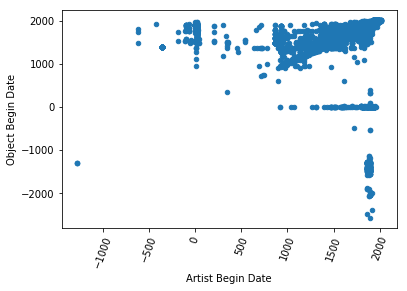

In [69]:
df.plot(kind='scatter', x='Artist Begin Date', y='Object Begin Date', rot=70)
plt.show()

In [79]:
# This looks strange.  Let's take a look at a couple examples that are far from a straight line with slope 1.
df_datesOff=df[(df['Object Begin Date']<-1000) & (df['Artist Begin Date']>1500)]
df_datesOff[['Department', 'Object Name', 'Object Begin Date', 'Artist Begin Date', 'Artist Display Name', 'Artist Nationality', 'Country', 'Region', 'Culture']]

,Department,Object Name,Object Begin Date,Artist Begin Date,Artist Display Name,Artist Nationality,Country,Region,Culture
89230,Costume Institute,Necklace,-2400,1914.0,Muriel Kallis Newman,American,NaN,NaN,Chinese
89313,Costume Institute,Necklace,-2000,1914.0,Muriel Kallis Newman,American,NaN,NaN,Chinese
351949,Egyptian Art,"Facsimile, Nefermaat and Itet, Meidum geese",-2575,1897.0,Charles K. Wilkinson,NaN,Egypt,Memphite Region,NaN
351950,Egyptian Art,"Facsimile, Mentuhotep II",-2051,1897.0,Charles K. Wilkinson,NaN,Egypt,"Upper Egypt, Thebes",NaN
351951,Egyptian Art,"Facsimile, Aashyt, sarcophagus",-2051,1897.0,Charles K. Wilkinson,NaN,Egypt,"Upper Egypt, Thebes",NaN
351952,Egyptian Art,"Facsimile, Aashyt sarcophagus",-2051,1897.0,Charles K. Wilkinson,NaN,Egypt,"Upper Egypt, Thebes",NaN
351954,Egyptian Art,"Facsimile, Aashyt sarcophagus",-2051,1897.0,Charles K. Wilkinson,NaN,Egypt,"Upper Egypt, Thebes",NaN
351955,Egyptian Art,"Facsimile, Khety (TT 311, MMA 508), friese d'o...",-2051,1897.0,Charles K. Wilkinson,NaN,Egypt,"Upper Egypt, Thebes",NaN
351956,Egyptian Art,"Facsimile, Khety (TT 311, MMA 508)",-2051,1897.0,Charles K. Wilkinson,NaN,Egypt,"Upper Egypt, Thebes",NaN
351957,Egyptian Art,"Facsimile, Khety (TT 311, MMA 508)",-2051,1897.0,Charles K. Wilkinson,NaN,Egypt,"Upper Egypt, Thebes",NaN


The artist in this case can mean philanthropists, curators, etc. responsible for the collection rather than the actual artist.  The Object Begin/End date is more meaningful with regards to dating the piece itself.

In [75]:
set(df['Artist Display Name'])

{nan,
 'Peter M. Brant|Castelli Graphics|Andy Warhol|Studio Heinrici',
 'Thomas Wallis I|Thomas Wallis II',
 'Chapman and Hall|George Baxter|George Jones',
 'Ludwig Bemelmans',
 'Horace Harral|Sir Edward Burne-Jones',
 'D. SWAROVSKI & CO.',
 'Charles Weitfle|Unknown',
 'Marks Adjustable Folding Chair Company',
 'Constantin Mitrofanovitsh Flórinsky',
 'Paul Bergon|Janet Reid|Eustace G. Calland|Ernest R. Ashton|William Crooke|Lionel C. Bennett|Alfred Stieglitz|Henry Van der Weyde|Paul Martin|Emile Joachim Constant Puyo|Henry Peach Robinson|Hans Watzek|W. Thomas|Heinrich Kühn|Robert Demachy|Alfred Horsley Hinton|Alfred Maskell|Walter L. Colls',
 'Balthasar Caymocx|Wendel Dietterlin, the Elder',
 'A. Calavas|Maurice-Jacques-Yvan Camus|Librairie des Arts Décoratifs',
 'Newcomb-Macklin Company',
 'Ramji',
 'Bennet',
 'Betye Saar',
 'Bartholomeus Spranger',
 'Wilbur Niewald',
 'Jan van Goyen',
 'L. Wolff Manufacturing Co.',
 'William Duff Taillefer',
 'Steiner Söhne',
 'Claes Oldenburg|Styria

In [59]:
list1=['American Decorative Arts',
 'Ancient Near Eastern Art',
 'Arms and Armor',
 'Arts of Africa, Oceania, and the Americas',
 'Asian Art',
 'Costume Institute',
 'Drawings and Prints',
 'Egyptian Art',
 'European Paintings',
 'European Sculpture and Decorative Arts',
 'Greek and Roman Art',
 'Islamic Art',
 'Medieval Art',
 'Modern and Contemporary Art',
 'Musical Instruments',
 'Photographs',
 'Robert Lehman Collection',
 'The Cloisters',
 'The Libraries']

In [64]:
# I used this for the app
for i in list1:
    print('<option value="'+i+'">'+i+'</option>')

<option value="American Decorative Arts">American Decorative Arts</option>
<option value="Ancient Near Eastern Art">Ancient Near Eastern Art</option>
<option value="Arms and Armor">Arms and Armor</option>
<option value="Arts of Africa, Oceania, and the Americas">Arts of Africa, Oceania, and the Americas</option>
<option value="Asian Art">Asian Art</option>
<option value="Costume Institute">Costume Institute</option>
<option value="Drawings and Prints">Drawings and Prints</option>
<option value="Egyptian Art">Egyptian Art</option>
<option value="European Paintings">European Paintings</option>
<option value="European Sculpture and Decorative Arts">European Sculpture and Decorative Arts</option>
<option value="Greek and Roman Art">Greek and Roman Art</option>
<option value="Islamic Art">Islamic Art</option>
<option value="Medieval Art">Medieval Art</option>
<option value="Modern and Contemporary Art">Modern and Contemporary Art</option>
<option value="Musical Instruments">Musical Instrume

In [ ]:
for i in list1:
    

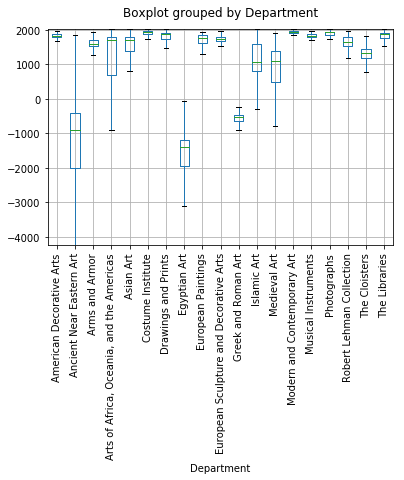

In [117]:
#Let's take a closer look at the date distribution to see if they make sense
fig, ax = plt.subplots()
box = df.boxplot(by='Department', column='Object Begin Date', rot=90, ax=ax, sym='') 
ax.margins(y=0)
plt.title("")
plt.show()


In [82]:
df.groupby('Department')['Culture'].value_counts()

Department                Culture                                         
American Decorative Arts  American                                            13857
                          Chinese, for American market                          452
                          British                                               406
                          British (American market)                             268
                          Mexican                                               261
                          Chinese                                               203
                          French                                                203
                          American or British                                   126
                          American, Shaker                                       86
                          British, probably                                      84
                          probably Ecuadoran, Quito                              45
 

One wouldn't expect too much cultural diversity in a department with a singular nationality (e.g. British art), but let's just look at 'Modern and Contemporary Art' and 'Photography.'  For example, let's look at the ratio of the conditional probability that some culture appears in a department compared to the unconditional probability.  This value can be skewed by rare labels on cultures, but it can also shed some light on how much more likely you are to see art from a culture in one department compared to the others.

In [132]:
cond_dict=(df.groupby('Department')['Culture'].value_counts()/df.groupby('Department')['Culture'].count()).to_dict()
uncond_dict=(df['Culture'].value_counts()/df.shape[0]).to_dict()

ratio_dict={}
for key in cond_dict.keys():
    ratio_dict[key]=cond_dict[key]/uncond_dict[key[1]]
sorted_ratio = sorted(ratio_dict, key=ratio_dict.get, reverse=True)
#print(sorted_ratio)
print("The largest ratios of conditional probability of a culture type given \
a department are to the unconditional probability of that type are: " )
for i in range(len(sorted_ratio)):
    print(i, sorted_ratio[i], ratio_dict[sorted_ratio[i]])


The largest ratios of conditional probability of a culture type given a department are to the unconditional probability of that type are: 
0 ('The Libraries', 'Amsterdam : Jacob von Meursen, 1681') 13641.33333333333
1 ('The Libraries', 'Antwerp: Ex Officina Plantíníana, 1595') 13641.33333333333
2 ('The Libraries', 'Anvers, 1628') 13641.33333333333
3 ('The Libraries', 'Boston: J. R. Osgood, 1885–1903') 13641.33333333333
4 ('The Libraries', 'Brescia: [s.n.], 1760') 13641.33333333333
5 ('The Libraries', 'Campidonae: Rudolphum Dreherr, 1673') 13641.33333333333
6 ('The Libraries', 'Hammersmith: Doves Press, 1902') 13641.33333333333
7 ('The Libraries', 'Leipzig, 1897–1913') 13641.33333333333
8 ('The Libraries', 'London : F. G. Moon, 1842–49') 13641.33333333333
9 ('The Libraries', 'London: Chiswick Press, 1910 (deluxe ed.)') 13641.33333333333
10 ('The Libraries', 'London: G. Bell, 1881') 13641.33333333333
11 ('The Libraries', 'London: J. M. Dent and Co., 1893') 13641.33333333333
12 ('The Libr

485 ('Musical Instruments', 'Guadalajara') 100.38593622240391
486 ('Musical Instruments', 'Indonesian (Sumatra)') 100.38593622240391
487 ('Musical Instruments', 'Indonesian (Sundanese)') 100.38593622240391
488 ('Musical Instruments', 'Indonesian?') 100.38593622240391
489 ('Musical Instruments', 'Italian (Pompeii)') 100.38593622240391
490 ('Musical Instruments', 'Kuba people') 100.38593622240391
491 ('Musical Instruments', 'Malian') 100.38593622240391
492 ('Musical Instruments', 'Mandinka people') 100.38593622240391
493 ('Musical Instruments', 'Maori') 100.38593622240391
494 ('Musical Instruments', 'Mayan') 100.38593622240391
495 ('Musical Instruments', 'Melanesian (Vanuatu)') 100.38593622240391
496 ('Musical Instruments', 'Mexican (Veracruz)') 100.38593622240391
497 ('Musical Instruments', 'Mpongwe people') 100.38593622240391
498 ('Musical Instruments', 'Native American (Allegheny band, Seneca people)') 100.38593622240391
499 ('Musical Instruments', 'Native American (Bora or Huitoto)')

819 ('Musical Instruments', 'Oaxaca?') 100.38593622240391
820 ('Musical Instruments', 'Papago') 100.38593622240391
821 ('Musical Instruments', 'Papua New Guinean (Bismarck Arcipelago)') 100.38593622240391
822 ('Musical Instruments', 'Papua New Guinean (Tolai People)') 100.38593622240391
823 ('Musical Instruments', 'Papua New Guinean (possibly Huon Gulf)') 100.38593622240391
824 ('Musical Instruments', 'Papuan New Guinean (New Ireland)') 100.38593622240391
825 ('Musical Instruments', 'Parisian (French)') 100.38593622240391
826 ('Musical Instruments', 'Pende') 100.38593622240391
827 ('Musical Instruments', 'Pende people, Kwango cluster') 100.38593622240391
828 ('Musical Instruments', 'Peruvian (Afro-Peruvian)') 100.38593622240391
829 ('Musical Instruments', 'Phililppine (Tagalog)') 100.38593622240391
830 ('Musical Instruments', 'Philippine (Igorot)') 100.38593622240391
831 ('Musical Instruments', 'Philippine (Luzon)') 100.38593622240391
832 ('Musical Instruments', "Philippine (Tagakaola 

1152 ('Medieval Art', 'Lower Rhenish or Saxon') 65.80302827281254
1153 ('Medieval Art', 'Ostrogothic (?)') 65.80302827281254
1154 ('Medieval Art', 'Roman or Celtic') 65.80302827281254
1155 ('Medieval Art', 'South Netherlandish or French') 65.80302827281254
1156 ('Medieval Art', 'Anglo-Scandinavian') 65.80302827281254
1157 ('Medieval Art', 'Austrian or South German') 65.80302827281254
1158 ('Medieval Art', 'Baltic or Scandinavian') 65.80302827281254
1159 ('Medieval Art', 'British (possibly Lincoln or York)') 65.80302827281254
1160 ('Medieval Art', 'British or European (?)') 65.80302827281254
1161 ('Medieval Art', 'British or South Netherlandish') 65.80302827281254
1162 ('Medieval Art', 'Byzantine (carving)') 65.80302827281254
1163 ('Medieval Art', 'Byzantine (ivory); Spanish (setting)') 65.80302827281254
1164 ('Medieval Art', 'Byzantine and Armenian') 65.80302827281254
1165 ('Medieval Art', 'Byzantine or Avar (?)') 65.80302827281254
1166 ('Medieval Art', 'Byzantine or Italian') 65.80302

1485 ('Arts of Africa, Oceania, and the Americas', 'Kuba peoples, Bushoong group') 38.54996467540623
1486 ('Arts of Africa, Oceania, and the Americas', 'Lakota (Teton Sioux)') 38.54996467540623
1487 ('Arts of Africa, Oceania, and the Americas', 'Mali') 38.54996467540623
1488 ('Arts of Africa, Oceania, and the Americas', 'Yoruba peoples, Ijebu group') 38.54996467540623
1489 ('Arts of Africa, Oceania, and the Americas', 'Dogon or Tellem  peoples (?)') 38.54996467540623
1490 ('Arts of Africa, Oceania, and the Americas', 'Hemba peoples') 38.54996467540623
1491 ('Arts of Africa, Oceania, and the Americas', 'Mossi peoples') 38.54996467540623
1492 ('Arts of Africa, Oceania, and the Americas', 'Zenú') 38.54996467540623
1493 ('Arts of Africa, Oceania, and the Americas', 'Bamessing') 38.54996467540623
1494 ('Arts of Africa, Oceania, and the Americas', 'Bamileke peoples') 38.54996467540623
1495 ('Arts of Africa, Oceania, and the Americas', 'Luzon Island') 38.54996467540623
1496 ('Arts of Africa, 

1818 ('Arts of Africa, Oceania, and the Americas', 'Alaska or British Columbia') 38.54996467540623
1819 ('Arts of Africa, Oceania, and the Americas', 'Ameca-Etzatlán') 38.54996467540623
1820 ('Arts of Africa, Oceania, and the Americas', 'Ancestral Pueblo (Mesa Verde)') 38.54996467540623
1821 ('Arts of Africa, Oceania, and the Americas', 'Aranta (?)') 38.54996467540623
1822 ('Arts of Africa, Oceania, and the Americas', 'Arapesh people') 38.54996467540623
1823 ('Arts of Africa, Oceania, and the Americas', 'Arikara') 38.54996467540623
1824 ('Arts of Africa, Oceania, and the Americas', 'Asante peoples') 38.54996467540623
1825 ('Arts of Africa, Oceania, and the Americas', 'Asmat people, As-Atat') 38.54996467540623
1826 ('Arts of Africa, Oceania, and the Americas', 'Asmat people, Kolopom') 38.54996467540623
1827 ('Arts of Africa, Oceania, and the Americas', 'Assiniboine or Gros Ventre') 38.54996467540623
1828 ('Arts of Africa, Oceania, and the Americas', 'Assiniboine or Sioux') 38.5499646754

2151 ('Arts of Africa, Oceania, and the Americas', 'Bwa peoples (?)') 38.54996467540623
2152 ('Arts of Africa, Oceania, and the Americas', 'B’Laan people') 38.54996467540623
2153 ('Arts of Africa, Oceania, and the Americas', 'Cajamarca') 38.54996467540623
2154 ('Arts of Africa, Oceania, and the Americas', 'Caldas (?)') 38.54996467540623
2155 ('Arts of Africa, Oceania, and the Americas', 'California') 38.54996467540623
2156 ('Arts of Africa, Oceania, and the Americas', 'Calima-Malagana') 38.54996467540623
2157 ('Arts of Africa, Oceania, and the Americas', 'Calusa (?)') 38.54996467540623
2158 ('Arts of Africa, Oceania, and the Americas', 'Capuli') 38.54996467540623
2159 ('Arts of Africa, Oceania, and the Americas', 'Caroline Islands (?)') 38.54996467540623
2160 ('Arts of Africa, Oceania, and the Americas', 'Caroline Islands, Nukuoro') 38.54996467540623
2161 ('Arts of Africa, Oceania, and the Americas', 'Caroline Islands, Pohnpei') 38.54996467540623
2162 ('Arts of Africa, Oceania, and the

2651 ('Arts of Africa, Oceania, and the Americas', 'Senufo or Bamana') 38.54996467540623
2652 ('Arts of Africa, Oceania, and the Americas', 'Senufo peoples, Tyebara group') 38.54996467540623
2653 ('Arts of Africa, Oceania, and the Americas', 'Shipibo') 38.54996467540623
2654 ('Arts of Africa, Oceania, and the Americas', 'Siane') 38.54996467540623
2655 ('Arts of Africa, Oceania, and the Americas', 'Sikyatki ') 38.54996467540623
2656 ('Arts of Africa, Oceania, and the Americas', 'Sioux (?)') 38.54996467540623
2657 ('Arts of Africa, Oceania, and the Americas', 'Sioux (Teton)') 38.54996467540623
2658 ('Arts of Africa, Oceania, and the Americas', 'Skiri Pawnee') 38.54996467540623
2659 ('Arts of Africa, Oceania, and the Americas', 'Slavey') 38.54996467540623
2660 ('Arts of Africa, Oceania, and the Americas', 'Somali peoples') 38.54996467540623
2661 ('Arts of Africa, Oceania, and the Americas', 'Somalia') 38.54996467540623
2662 ('Arts of Africa, Oceania, and the Americas', 'Songue peoples (Ek

2984 ('Arms and Armor', 'Indian, possibly North Indian') 36.18124217195903
2985 ('Arms and Armor', 'Indian, probably Deccan') 36.18124217195903
2986 ('Arms and Armor', 'Indian, probably Sikh') 36.18124217195903
2987 ('Arms and Armor', 'Indonesian, Gorontalo') 36.18124217195903
2988 ('Arms and Armor', 'Indonesian, Lombok') 36.18124217195903
2989 ('Arms and Armor', 'Indonesian, Sulawesi (possibly the Philippines)') 36.18124217195903
2990 ('Arms and Armor', 'Italian or possibly French') 36.18124217195903
2991 ('Arms and Armor', 'Italian, Bargi') 36.18124217195903
2992 ('Arms and Armor', 'Italian, probably Bologna') 36.18124217195903
2993 ('Arms and Armor', 'Japanese, Nagasaki') 36.18124217195903
2994 ('Arms and Armor', 'Javanese, possibly Madura') 36.18124217195903
2995 ('Arms and Armor', 'Kingdom of Jerusalem (near modern day ʻAkko, Israel)') 36.18124217195903
2996 ('Arms and Armor', 'Korean or Chinese') 36.18124217195903
2997 ('Arms and Armor', 'Native American, Plains') 36.181242171959

3484 ('Arms and Armor', 'Probably South German or Austrian') 36.18124217195903
3485 ('Arms and Armor', 'Probably Viennese') 36.18124217195903
3486 ('Arms and Armor', 'Roman or Thracian') 36.18124217195903
3487 ('Arms and Armor', 'Roman, Herculaneum') 36.18124217195903
3488 ('Arms and Armor', 'Roman-Germanic') 36.18124217195903
3489 ('Arms and Armor', 'Russian, Saint Petersburg') 36.18124217195903
3490 ('Arms and Armor', 'Savoyard') 36.18124217195903
3491 ('Arms and Armor', 'Scandinavian, possibly Danish') 36.18124217195903
3492 ('Arms and Armor', 'Scythian or Sarmatian') 36.18124217195903
3493 ('Arms and Armor', 'Siberian, Lamut; lock, Russian') 36.18124217195903
3494 ('Arms and Armor', 'Silesian, Cieszyn') 36.18124217195903
3495 ('Arms and Armor', 'Silesian, Teschen') 36.18124217195903
3496 ('Arms and Armor', 'Silesian, probably Teschen') 36.18124217195903
3497 ('Arms and Armor', 'Singpho, Burma') 36.18124217195903
3498 ('Arms and Armor', 'So. German') 36.18124217195903
3499 ('Arms an

3984 ('Musical Instruments', 'Bulgarian') 26.769582992641045
3985 ('Musical Instruments', 'Cambodian') 26.769582992641045
3986 ('Musical Instruments', 'Indian') 26.353006261361788
3987 ('The Cloisters', 'Austrian') 25.87436210088967
3988 ('Robert Lehman Collection', 'German (?)') 25.768076398362894
3989 ('Arts of Africa, Oceania, and the Americas', 'Makonde') 25.69997645027082
3990 ('Arts of Africa, Oceania, and the Americas', 'Nariño') 25.69997645027082
3991 ('Arts of Africa, Oceania, and the Americas', 'Southern Arapaho') 25.69997645027082
3992 ('Arts of Africa, Oceania, and the Americas', 'Tyrol') 25.69997645027082
3993 ('Musical Instruments', 'Philippine') 25.654183701281006
3994 ('The Cloisters', 'Spanish') 25.494877711121365
3995 ('The Cloisters', 'Franco-Flemish') 25.366115702479334
3996 ('The Cloisters', 'German or Bohemian') 25.366115702479334
3997 ('Arms and Armor', 'Balinese') 25.16955977179759
3998 ('Musical Instruments', 'probably Chinese') 25.09648405560098
3999 ('Musical

4472 ('Greek and Roman Art', 'Greek, Egypt') 15.176710550713885
4473 ('Greek and Roman Art', 'Greek, Ionian ?') 15.176710550713885
4474 ('Greek and Roman Art', 'Greek, Kos') 15.176710550713885
4475 ('Greek and Roman Art', 'Greek, Laconian?') 15.176710550713885
4476 ('Greek and Roman Art', 'Greek, Lesbian') 15.176710550713885
4477 ('Greek and Roman Art', 'Greek, Locrian possibly') 15.176710550713885
4478 ('Greek and Roman Art', 'Greek, Peloponnesian-Elis') 15.176710550713885
4479 ('Greek and Roman Art', 'Greek, Pergamene (?)') 15.176710550713885
4480 ('Greek and Roman Art', 'Greek, Phokis') 15.176710550713885
4481 ('Greek and Roman Art', 'Greek, Pontus') 15.176710550713885
4482 ('Greek and Roman Art', 'Greek, Protoattic') 15.176710550713885
4483 ('Greek and Roman Art', 'Greek, Ptolemaic Egyptian') 15.176710550713885
4484 ('Greek and Roman Art', 'Greek, Ptolemaic or Roman') 15.176710550713885
4485 ('Greek and Roman Art', 'Greek, Ptolemaic or Roman, Egyptian') 15.176710550713885
4486 ('Gr

4817 ('Asian Art', 'Vietnam (North, Dong Song Culture)') 13.151089925552997
4818 ('Asian Art', 'Vietnam (North, Highlands)') 13.151089925552997
4819 ('Asian Art', 'Vietnam or Cambodia') 13.151089925552997
4820 ('Asian Art', 'Vietnam(?)') 13.151089925552997
4821 ('Asian Art', 'Western Tibet') 13.151089925552997
4822 ('Asian Art', 'Xinjiang Uyghur Autonomous Region') 13.151089925552997
4823 ('Asian Art', 'Afghanistan (probably Hadda)') 13.151089925552997
4824 ('Asian Art', 'Afghanistan, possibly of West Indian manufacture') 13.151089925552997
4825 ('Asian Art', 'Asia or America') 13.151089925552997
4826 ('Asian Art', 'Bangladesh (probably Comilla District)') 13.151089925552997
4827 ('Asian Art', 'Bengal, eastern India or Bangladesh') 13.151089925552997
4828 ('Asian Art', 'Burma or Thailand') 13.151089925552997
4829 ('Asian Art', 'Burmese (Haka)') 13.151089925552997
4830 ('Asian Art', 'Burmese (Mara)') 13.151089925552997
4831 ('Asian Art', 'China (Dian culture)') 13.151089925552997
4832 (

5317 ('Asian Art', 'Volga region, Russia') 13.151089925552997
5318 ('Asian Art', 'Western India, Bikaner, Rajasthan') 13.151089925552997
5319 ('Asian Art', 'Western India, Rajasthan, Bikaner') 13.151089925552997
5320 ('Asian Art', 'Western India, Rajasthan, Devgarh') 13.151089925552997
5321 ('Asian Art', 'Western India, Rajasthan, Jaipur or Unaira') 13.151089925552997
5322 ('Asian Art', 'Western India, Rajasthan, Jhilai') 13.151089925552997
5323 ('Asian Art', 'Western India, Rajasthan, Mewar') 13.151089925552997
5324 ('Asian Art', 'Western India, Rajasthan, Udaipur or Devgarh') 13.151089925552997
5325 ('Asian Art', 'Western India, Rajasthan, Udaipur or Kota') 13.151089925552997
5326 ('Asian Art', 'Western Pakistan') 13.151089925552997
5327 ('Asian Art', 'Western Tibet or Ladakh') 13.151089925552997
5328 ('Asian Art', 'china') 13.151089925552997
5329 ('Asian Art', 'probably Germany for the Indian market') 13.151089925552997
5330 ('Asian Art', 'probably Japan') 13.151089925552997
5331 ('

5817 ('European Sculpture and Decorative Arts', 'Italian, probably Pesaro') 11.443538239269234
5818 ('European Sculpture and Decorative Arts', 'Polish, Kobylka') 11.443538239269234
5819 ('European Sculpture and Decorative Arts', 'Spanish, Alcora') 11.443538239269234
5820 ('European Sculpture and Decorative Arts', 'Spanish, Castile') 11.443538239269234
5821 ('European Sculpture and Decorative Arts', 'Swedish, Vadstena') 11.443538239269234
5822 ('European Sculpture and Decorative Arts', 'Austrian, Moravia') 11.443538239269234
5823 ('European Sculpture and Decorative Arts', 'Austrian, Vienna with German, Breslau decoration') 11.443538239269234
5824 ('European Sculpture and Decorative Arts', 'British and French, probably Beauvais') 11.443538239269234
5825 ('European Sculpture and Decorative Arts', 'British, Birmingham, after Portuguese original') 11.443538239269234
5826 ('European Sculpture and Decorative Arts', 'British, East Midlands (?)') 11.443538239269234
5827 ('European Sculpture and

6316 ('European Sculpture and Decorative Arts', 'British, Sunderland, Yorkshire') 11.443538239269234
6317 ('European Sculpture and Decorative Arts', 'British, Torquay') 11.443538239269234
6318 ('European Sculpture and Decorative Arts', 'British, Tunstall, Staffordshire') 11.443538239269234
6319 ('European Sculpture and Decorative Arts', 'British, Warrington') 11.443538239269234
6320 ('European Sculpture and Decorative Arts', 'British, Worcester or Caughley') 11.443538239269234
6321 ('European Sculpture and Decorative Arts', 'British, Worcestershire with French, Paris (Gobelins) tapestry') 11.443538239269234
6322 ('European Sculpture and Decorative Arts', 'British, Worchester') 11.443538239269234
6323 ('European Sculpture and Decorative Arts', 'British, after Danish original') 11.443538239269234
6324 ('European Sculpture and Decorative Arts', 'British, after Dutch, Amsterdam or Haarlem original') 11.443538239269234
6325 ('European Sculpture and Decorative Arts', 'British, after Dutch, B

6650 ('European Sculpture and Decorative Arts', 'German, Freystadt') 11.443538239269234
6651 ('European Sculpture and Decorative Arts', 'German, Fürton') 11.443538239269234
6652 ('European Sculpture and Decorative Arts', 'German, Hamburg (Altona)') 11.443538239269234
6653 ('European Sculpture and Decorative Arts', 'German, Hanau with Nuremberg') 11.443538239269234
6654 ('European Sculpture and Decorative Arts', 'German, Hanau with Nuremberg decoration') 11.443538239269234
6655 ('European Sculpture and Decorative Arts', 'German, Hanau-Frankfurt') 11.443538239269234
6656 ('European Sculpture and Decorative Arts', 'German, Hanover (Kalenberg)') 11.443538239269234
6657 ('European Sculpture and Decorative Arts', 'German, Hesse') 11.443538239269234
6658 ('European Sculpture and Decorative Arts', 'German, Hesse or Swedish') 11.443538239269234
6659 ('European Sculpture and Decorative Arts', 'German, Hildesheim') 11.443538239269234
6660 ('European Sculpture and Decorative Arts', 'German, Höchst

6950 ('European Sculpture and Decorative Arts', 'Italian, possibly Turin') 11.443538239269234
6951 ('European Sculpture and Decorative Arts', 'Italian, possibly Urbino') 11.443538239269234
6952 ('European Sculpture and Decorative Arts', 'Italian, possibly Urbino with Gubbio luster') 11.443538239269234
6953 ('European Sculpture and Decorative Arts', 'Italian, possibly Verona') 11.443538239269234
6954 ('European Sculpture and Decorative Arts', 'Italian, probably Castelli') 11.443538239269234
6955 ('European Sculpture and Decorative Arts', 'Italian, probably Ferrara') 11.443538239269234
6956 ('European Sculpture and Decorative Arts', 'Italian, probably Lombardy') 11.443538239269234
6957 ('European Sculpture and Decorative Arts', 'Italian, probably Milan or Mantua') 11.443538239269234
6958 ('European Sculpture and Decorative Arts', 'Italian, probably Montelupo') 11.443538239269234
6959 ('European Sculpture and Decorative Arts', 'Italian, probably Naples or Naples district') 11.443538239269

7483 ('Costume Institute', 'Chinese (Han)') 7.8206198044399144
7484 ('Costume Institute', 'possibly Moroccan') 7.8206198044399144
7485 ('Costume Institute', 'probably Norwegian') 7.8206198044399144
7486 ('European Sculpture and Decorative Arts', 'probably Italian') 7.765258090932696
7487 ('European Sculpture and Decorative Arts', 'Portuguese') 7.748229016171878
7488 ('Musical Instruments', 'Asmat') 7.7219950940310715
7489 ('Musical Instruments', 'European') 7.705140975964798
7490 ('Musical Instruments', 'Aztec') 7.648452283611728
7491 ('European Sculpture and Decorative Arts', 'possibly Portuguese') 7.629025492846157
7492 ('European Sculpture and Decorative Arts', 'Austrian, Hall') 7.629025492846157
7493 ('European Sculpture and Decorative Arts', 'French, possibly Paris') 7.629025492846157
7494 ('European Sculpture and Decorative Arts', 'Belgian, Bruges') 7.629025492846157
7495 ('European Sculpture and Decorative Arts', 'Bohemian or Moravian') 7.629025492846157
7496 ('European Sculptur

7982 ('Arms and Armor', 'Italian, Tuscany') 1.2060414057319677
7983 ('Arms and Armor', 'Italian, possibly Florence') 1.2060414057319677
7984 ('Ancient Near Eastern Art', 'Lydian') 1.1927659925872311
7985 ('Musical Instruments', 'American') 1.1758597475134724
7986 ('Costume Institute', 'Japanese') 1.1491309781110577
7987 ('Arms and Armor', 'Portuguese') 1.1306638178737198
7988 ('Robert Lehman Collection', 'British') 1.1222277828432752
7989 ('Musical Instruments', 'Flemish') 1.1195457571271814
7990 ('Musical Instruments', 'Moche') 1.118506253174417
7991 ('Robert Lehman Collection', 'Roman') 1.0989870598440603
7992 ('Costume Institute', 'Indian') 1.0794360217224237
7993 ('Arms and Armor', 'British, London') 1.073394304667381
7994 ('European Sculpture and Decorative Arts', 'Romanian') 1.0403216581153851
7995 ('European Sculpture and Decorative Arts', 'Scandinavian') 1.0403216581153851
7996 ('Asian Art', 'Indian') 1.0321559075535505
7997 ('Arms and Armor', 'British') 1.0235527284827421
7998

# Predictions

Let's see if we can predict what department a piece belongs to based on its title.  This is inspired by a spam filter (https://radimrehurek.com/data_science_python/) and uses a bag-of-words model with SKLearn.

In [151]:
regex = re.compile('[%s]' % re.escape(string.punctuation))
def puncRM_re(s):
    return regex.sub('', s)

In [182]:
# This manually splits up the words, not actually used here.

#train, validate, test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])
#word_dict={}
#for i in list1:
#    df_temp1=train[pd.notnull(train['Object Name'])]
#    word_dict[i]=[]
#    df_temp=df_temp1[df_temp1['Department']==i]
#    for index, row in df_temp.iterrows():
#        #print(row['Object Name'])
#        row1=puncRM_re(row['Object Name'])
#        row1=" ".join(row1.split())
#        row1=row1.strip()
#        row2=row1.split(' ')
#        if len(row2)<2: continue #Single words can be too descriptive
#        for j in row2:
#            word1=j.replace(" ", "").lower()
#            word_dict[i].append(word1)


In [13]:
# 
count_vect = CountVectorizer()
tfidf_transformer = TfidfTransformer()

In [12]:
# Make a function that gets rid of punctuation and numbers and any stopwords
def text_process(mess):
    numlist=["0","1","2","3","4","5","6","7","8","9"]
    mess=str(mess)
    nopunc = [char for char in mess if char not in string.punctuation and char not in numlist]

    nopunc = ''.join(nopunc)
    
    
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [14]:
# split titles into tokens
def split_into_lemmas(title):
    title=str(title)
    title = title.lower()
    words = TextBlob(title).words
    return [word.lemma for word in words]

In [344]:
split_into_lemmas(df.iloc[20000]['Title'])

['pair', 'of', 'underarm', 'defense']

In [328]:
npTitle=np.array(df['Title'], dtype=pd.Series)

In [341]:
split_into_lemmas(npTitle[20000])

['pair', 'of', 'underarm', 'defense']

In [345]:
# create a bag of words transformor 
# We need to count the word frequency and weight it inversely to how frequently it appears in the corpus

bow_transformer = CountVectorizer(analyzer=split_into_lemmas).fit(df['Title'])

In [347]:
print(len(bow_transformer.vocabulary_))

112004


In [350]:
title_bow = bow_transformer.transform(df['Title'])



In [352]:
print('sparse matrix shape:', title_bow.shape)
print('number of non-zeros:', title_bow.nnz)
print('sparsity: %.2f%%' % (100.0 * title_bow.nnz / (title_bow.shape[0] * title_bow.shape[1])))

sparse matrix shape: (491088, 112004)
number of non-zeros: 2948752
sparsity: 0.01%


In [353]:
#Weight and normalize with TF-IDF
tfidf_transformer = TfidfTransformer().fit(title_bow)

In [354]:
title_tfidf = tfidf_transformer.transform(title_bow)

In [355]:
# Now let's train a model - we'll start with 
art_detector = MultinomialNB().fit(title_tfidf, df['Department'])

In [363]:
print('predicted:', art_detector.predict(title_tfidf[20000])[0])
print('expected:', df.iloc[20000]['Department'])

predicted: Arms and Armor
expected: Arms and Armor


In [361]:
# That one looks good, let's check all the samples:
all_predictions = art_detector.predict(title_tfidf)
print('accuracy', accuracy_score(df['Department'], all_predictions))
print('confusion matrix\n', confusion_matrix(df['Department'], all_predictions))
print('(row=expected, col=predicted)')

accuracy 0.7716498875965204
confusion matrix
 [[  3999      8     35     19      6    311   8515    197      0   3620
    1423     18      1      4      6    319      0      0      0]
 [     7   1972    230     72      4    257    899   1698      0    211
     779     30     10      2      2     13      0      0      0]
 [     1      0  11209     41      2    246   1597    129      0    146
     179      5      2      0      1     16      0      0      0]
 [     5     15    193   6490     14    528   3212    842      0    880
     548     90      5     39     30    139      0      0      0]
 [     8      0      4      5  35939     12   1039     76      0    156
      46      1      0      0      0     87      0      0      0]
 [    32      3     40     44     13  28846   1184     75      0    833
     170     20      0     50      0     99      0      0      0]
 [    59      1     27     21    102    109 173446     87      0    302
     102      7      0    251      2   1088      0    

In [364]:
print(classification_report(df['Department'], all_predictions))

/Users/ian/.pyenv/versions/3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                                           precision    recall  f1-score   support

                 American Decorative Arts       0.84      0.22      0.34     18481
                 Ancient Near Eastern Art       0.84      0.32      0.46      6186
                           Arms and Armor       0.91      0.83      0.87     13574
Arts of Africa, Oceania, and the Americas       0.90      0.50      0.64     13030
                                Asian Art       0.99      0.96      0.98     37373
                        Costume Institute       0.88      0.92      0.90     31409
                      Drawings and Prints       0.73      0.99      0.84    175604
                             Egyptian Art       0.80      0.82      0.81     27914
                       European Paintings       0.00      0.00      0.00      2941
   European Sculpture and Decorative Arts       0.69      0.68      0.69     42981
                      Greek and Roman Art       0.65      0.93      0.76     33698
   

We just tested on the training set, which is never ok but just done for demonstration on individual steps - so we'll produce a pipeline instead and split data into training and testing.

In [15]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=split_into_lemmas)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [20]:
title_train, title_test, label_train, label_test =  train_test_split(df['Title'], df['Department'], test_size=0.2)
title_train_list, title_test_list, label_train_list, label_test = list(title_train), list(title_test), list(label_train), list(label_test)

In [22]:
scores = cross_val_score(pipeline,
                         title_train_list,  
                         label_train_list,  
                         cv=10,  # split data randomly into 10 parts: 9 for training, 1 for scoring
                         scoring='accuracy',  
                         n_jobs=-1,  # -1 = use all cores
                         )
print(scores)

[0.74868311 0.7507062  0.75043901 0.74781746 0.74571094 0.74824997
 0.74912812 0.74543696 0.74717413 0.74655668]


We consistently get around 75% accuracy.  We can tweak a few things though and repeat.

In [31]:
#Instead of using lemmas, just use tokens
def split_into_tokens(title):
    title = str(title)
    return TextBlob(title).words

In [32]:
params = {
    'tfidf__use_idf': (True, False),
    'bow__analyzer': (split_into_lemmas, split_into_tokens),
}

grid = GridSearchCV(
    pipeline,  # pipeline from above
    params,  # parameters to tune via cross validation
    refit=True,  # fit using all available data at the end, on the best found param combination
    n_jobs=-1,  # number of cores to use for parallelization; -1 for "all cores"
    scoring='accuracy',  # what score are we optimizing?
    cv=StratifiedKFold(),  # what type of cross validation to use
)

/Users/ian/.pyenv/versions/3.6.5/lib/python3.6/site-packages/sklearn/model_selection/_split.py:624: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


In [33]:
nb_detector = grid.fit(title_train_list, label_train_list)


AttributeError: 'GridSearchCV' object has no attribute 'grid_scores_'

In [45]:
print(nb_detector.best_score_)
print(nb_detector.best_params_)

0.7670730776083692
{'bow__analyzer': <function split_into_tokens at 0x10b09c268>, 'tfidf__use_idf': True}


In [35]:
predictions = nb_detector.predict(title_test_list)
print(confusion_matrix(label_test, predictions))
print(classification_report(label_test, predictions))

[[  861     0    10    14     2    64  1697    51     0   702   143    69
      0     2     1    61     0     0     0]
 [    2   400    37    26     0    46   129   345     0    72   111    38
      0     0     0     2     0     0     0]
 [    0     0  2343    36     1    17   323    20     0    26     1    28
      1     0     0     4     0     0     0]
 [    4     2    81  1412     3   116   504   173     0   150    25    63
      1     5     8    33     0     0     0]
 [    2     0     4     2  6777     2   448    12     0    40    11     1
      0     0     0    16     0     0     0]
 [    2     0     4    15     4  5859   220    36     0   143     0     8
      0     8     0     8     0     0     0]
 [    8     0     4     9     7    10 34923    16     0    48     9     1
      0    55     0   246     0     0     0]
 [    1    19    57    25     0    39   416  4669     0   159   213    34
      0     0     0    19     0     0     0]
 [    0     0     0     0     0     0   539     

/Users/ian/.pyenv/versions/3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                                           precision    recall  f1-score   support

                 American Decorative Arts       0.86      0.23      0.37      3677
                 Ancient Near Eastern Art       0.94      0.33      0.49      1208
                           Arms and Armor       0.89      0.84      0.86      2800
Arts of Africa, Oceania, and the Americas       0.85      0.55      0.67      2580
                                Asian Art       0.99      0.93      0.96      7315
                        Costume Institute       0.90      0.93      0.91      6307
                      Drawings and Prints       0.71      0.99      0.83     35336
                             Egyptian Art       0.79      0.83      0.81      5651
                       European Paintings       0.00      0.00      0.00       565
   European Sculpture and Decorative Arts       0.69      0.69      0.69      8488
                      Greek and Roman Art       0.88      0.92      0.90      6694
   

Let's see if an SVM gives better results

In [36]:
pipeline_svm = Pipeline([
    ('bow', CountVectorizer(analyzer=split_into_lemmas)),
    ('tfidf', TfidfTransformer()),
    ('classifier', SVC()), 
])

# pipeline parameters to automatically explore and tune
param_svm = [
  {'classifier__C': [1, 10, 100, 1000], 'classifier__kernel': ['linear']},
  {'classifier__C': [1, 10, 100, 1000], 'classifier__gamma': [0.001, 0.0001], 'classifier__kernel': ['rbf']},
]

grid_svm = GridSearchCV(
    pipeline_svm,  # pipeline from above
    param_grid=param_svm,  # parameters to tune via cross validation
    refit=True,  # fit using all data, on the best detected classifier
    n_jobs=-1,  # number of cores to use for parallelization; -1 for "all cores"
    scoring='accuracy',  # what score are we optimizing?
    cv=StratifiedKFold(),  # what type of cross validation to use
)

/Users/ian/.pyenv/versions/3.6.5/lib/python3.6/site-packages/sklearn/model_selection/_split.py:624: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


A grid search takes too long on a personal computer, but the code below can be run to optimize the model on the cloud.

In [44]:
##split into a smaller data set to work with an SVM
## SVMs take too long to train on very large datasets, so use 1/10 total set
#title_train_svm, title_test_svm, label_train_svm, label_test_svm =  train_test_split(title_train_list, label_train_list, test_size=0.9)

#svm_detector = grid_svm.fit(title_train_svm, label_train_svm) # find the best combination from param_svm


In [ ]:
#print(svm_detector.grid_scores_)

In [ ]:
#print(confusion_matrix(label_test_list, svm_detector.predict(title_test_list)))
#print(classification_report(label_test_list, svm_detector.predict(title_test_list)))

In [50]:
pipeline_svc = Pipeline([
    ('bow', CountVectorizer(analyzer=split_into_lemmas)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', SVC()),  # train on TF-IDF vectors w/ svm
])


In [52]:
scores = cross_val_score(pipeline_svc,
                         title_train_svm,  
                         label_train_svm,  
                         cv=10,  # split data randomly into 10 parts: 9 for training, 1 for scoring
                         scoring='accuracy',  
                         n_jobs=-1,  # -1 = use all cores
                         )
print(scores)

KeyboardInterrupt: 